Тюнинг параметров моделей с помощью keras tuner

# НА 18 ДИАГНОЗАХ

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner as kt
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
diplo = '/content/drive/MyDrive/Colab Notebooks/диплом пробую тут/'

In [ ]:
dataKNN = pd.read_excel('dataKNN18.xlsx')
mice_blood = pd.read_excel('mice_blood18.xlsx')

In [ ]:
def diagPreprocess(TARGET: pd.Series):
    TARGET = TARGET.str.replace(';+', ';', regex=True)
    TARGET = TARGET.str.replace(';$', '', regex=True)
    TARGET = TARGET.str.split(';')
    return TARGET

In [ ]:
dataKNN['diag'] = diagPreprocess(dataKNN['diag'])
mice_blood['diag'] = diagPreprocess(mice_blood['diag'])

In [ ]:
def MakeY(Y_col):
  mlb = preprocessing.MultiLabelBinarizer(sparse_output=True)
  Y = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(Y_col), columns=mlb.classes_)
  return Y

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
dX = scaler.fit_transform(dataKNN.iloc[:, :-1])
dY = MakeY(dataKNN['diag'])
mX = scaler.fit_transform(mice_blood.iloc[:, :-1])
mY = MakeY(mice_blood['diag'])

In [ ]:
mY.shape

(19324, 18)

In [ ]:
diags_desc = mY.sum().sort_values(ascending=False)
print(diags_desc)

Z         8379
J         3450
I         3238
M         1955
H         1879
E         1378
N         1250
G         1248
K         1161
C         1013
L          730
D          492
S          367
O          257
A          254
R          189
Q          168
Другое     104
dtype: int64


In [ ]:
def plothistory(history, metric='accuracy'):
    acc = history.history[metric]
    val_acc = history.history[f"val_{metric}"]
    if metric == 'f1_score':
        acc = [np.average(x) for x in acc]
        val_acc = [np.average(x) for x in val_acc]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(epochs, acc, label="Точность на этапе обучения", color='brown')
    ax[0].plot(epochs, val_acc, "b", label="Точность на этапе проверки")
    ax[0].set_title("Точность на этапах обучения и проверки")
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(epochs, loss, label="Потери на этапе обучения", color='brown')
    ax[1].plot(epochs, val_loss, "b", label="Потери на этапе проверки")
    ax[1].set_title("Потери на этапах обучения и проверки")
    ax[1].legend()
    ax[1].grid(True)
    fig.show()

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
def trtestsplit(X, Y, splsize=0.2):
    X_train, y_train, xval, yval = iterative_train_test_split(np.array(X), np.array(Y), test_size=splsize)
    X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(X_train), np.array(y_train), test_size=splsize)
    X_train = tf.constant(X_train, dtype=tf.float32); y_train = tf.constant(y_train, dtype=tf.float32)
    X_test = tf.constant(X_test, dtype=tf.float32); y_test = tf.constant(y_test, dtype=tf.float32)
    xval = tf.constant(xval, dtype=tf.float32); yval = tf.constant(yval, dtype=tf.float32)
    return X_train, y_train, X_test, y_test, xval, yval

In [ ]:
#!rm -rf drive/MyDrive/Colab\ Notebooks/'диплом пробую тут'/mblood

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, average_precision_score

**ЧЕРНОВАЯ ПОПЫТКА С ПОТОЛКА**
model = keras.models.Sequential()
model.add = keras.Input(shape=(X_train.shape[1],)),
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(7, activation='sigmoid'))
model.add(keras.layers.Dense(5, activation='relu'))
model.add(keras.layers.Dense(16, activation='sigmoid'))
model.add(keras.layers.Dense(Y.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam, metrics=keras.metrics.F1Score(average='weighted'))
  #binary_crossentropy
  #sparse_categorical_crossentropy
model.summary()
callbacks = [keras.callbacks.ModelCheckpoint(filepath=diplo+"bloodHistory.keras", save_best_only=True, monitor="val_loss")]

  #history = model.fit(scaled_X_train, y_train, batch_size=8, epochs=240, steps_per_epoch=10)
history = model.fit(X_train, y_train, batch_size=8, epochs=100, callbacks=callbacks, validation_data=(xval, yval))

# Dropout, batchnorm на датакнн

In [ ]:
X_train, y_train, X_test, y_test, xval, yval = trtestsplit(dX, dY, 0.2)

In [ ]:
def model_builder(hp):
    inp = tf.keras.layers.Input(shape = (X_train.shape[1],))
    x = tf.keras.layers.BatchNormalization()(inp)
    num_layers = hp.Int('num_layers', 3, 66, step=1)
    for i in range(num_layers):
        nunits = hp.Int(f'units{i}', min_value=3, max_value=100)
        act = hp.Choice(f'activation{i}', ['relu', 'sigmoid', 'leaky_relu', 'elu', 'selu', 'swish'])
        x = keras.layers.Dense(units=nunits, activation=act)(x)
    drop_rate = hp.Choice(f'drate{i}', [0.25,0.3,0.35,0.4,0.45,0.5,0.55, 0.6, 0.65,0.7])
    x = keras.layers.Dropout(drop_rate)(x)
    outputs = tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')(x)
    model = keras.Model(inp, outputs)

    #lr = hp.Float('learning_rate', 0.0005, 0.02)

    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(), #learning_rate=lr
                  metrics=keras.metrics.F1Score(average='weighted'))
    return model

In [ ]:
tuner0 = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=150,
                     #validation_data=(xval, yval),
                     directory=diplo+'dknn18',
                     project_name='dknn18')
callbacks0=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')]#, patience=15
tuner0.search(X_train, y_train, validation_data=(xval, yval),
              epochs = 10, batch_size = 4,
              callbacks = callbacks0, verbose = 1)

Trial 254 Complete [00h 01m 23s]
val_loss: 0.22700656950473785

Best val_loss So Far: 0.2009468376636505
Total elapsed time: 08h 41m 54s


In [ ]:
best_hps0 = tuner0.get_best_hyperparameters()
best_hps0[0].values

{'num_layers': 3,
 'units0': 34,
 'activation0': 'sigmoid',
 'units1': 60,
 'activation1': 'leaky_relu',
 'units2': 98,
 'activation2': 'leaky_relu',
 'drate2': 0.45,
 'units3': 17,
 'activation3': 'sigmoid',
 'units4': 38,
 'activation4': 'elu',
 'units5': 8,
 'activation5': 'leaky_relu',
 'units6': 36,
 'activation6': 'elu',
 'units7': 51,
 'activation7': 'swish',
 'units8': 45,
 'activation8': 'selu',
 'units9': 61,
 'activation9': 'relu',
 'units10': 32,
 'activation10': 'sigmoid',
 'units11': 51,
 'activation11': 'swish',
 'units12': 99,
 'activation12': 'sigmoid',
 'units13': 62,
 'activation13': 'swish',
 'units14': 13,
 'activation14': 'relu',
 'units15': 4,
 'activation15': 'selu',
 'units16': 43,
 'activation16': 'elu',
 'units17': 39,
 'activation17': 'leaky_relu',
 'units18': 10,
 'activation18': 'elu',
 'units19': 9,
 'activation19': 'elu',
 'units20': 56,
 'activation20': 'relu',
 'units21': 29,
 'activation21': 'selu',
 'units22': 46,
 'activation22': 'selu',
 'units23':

In [ ]:
best05 = tuner0.get_best_hyperparameters(5)
model0 = tuner0.hypermodel.build(best_hps0[0])
history0 = model0.fit(X_train, y_train, epochs=100, validation_data=(xval, yval))
val_per_epoch0 = history0.history['val_loss']

Epoch 1/100
389/389 [==============================] - 3s 4ms/step - loss: 0.2457 - f1_score: 0.2466 - val_loss: 0.2073 - val_f1_score: 0.2742
Epoch 2/100
389/389 [==============================] - 1s 3ms/step - loss: 0.2119 - f1_score: 0.2677 - val_loss: 0.2034 - val_f1_score: 0.2739
Epoch 3/100
389/389 [==============================] - 2s 6ms/step - loss: 0.2085 - f1_score: 0.2676 - val_loss: 0.2029 - val_f1_score: 0.2743
Epoch 4/100
389/389 [==============================] - 3s 8ms/step - loss: 0.2072 - f1_score: 0.2680 - val_loss: 0.2015 - val_f1_score: 0.2762
Epoch 5/100
389/389 [==============================] - 2s 5ms/step - loss: 0.2057 - f1_score: 0.2701 - val_loss: 0.2008 - val_f1_score: 0.2748
Epoch 6/100
389/389 [==============================] - 2s 5ms/step - loss: 0.2049 - f1_score: 0.2713 - val_loss: 0.2002 - val_f1_score: 0.2760
Epoch 7/100
389/389 [==============================] - 2s 5ms/step - loss: 0.2047 - f1_score: 0.2707 - val_loss: 0.2002 - val_f1_score: 0.2804

In [ ]:
model0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17)]              0         
                                                                 
 batch_normalization_1 (Bat  (None, 17)                68        
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 34)                612       
                                                                 
 dense_35 (Dense)            (None, 60)                2100      
                                                                 
 dense_36 (Dense)            (None, 98)                5978      
                                                                 
 dropout_1 (Dropout)         (None, 98)                0         
                                                           

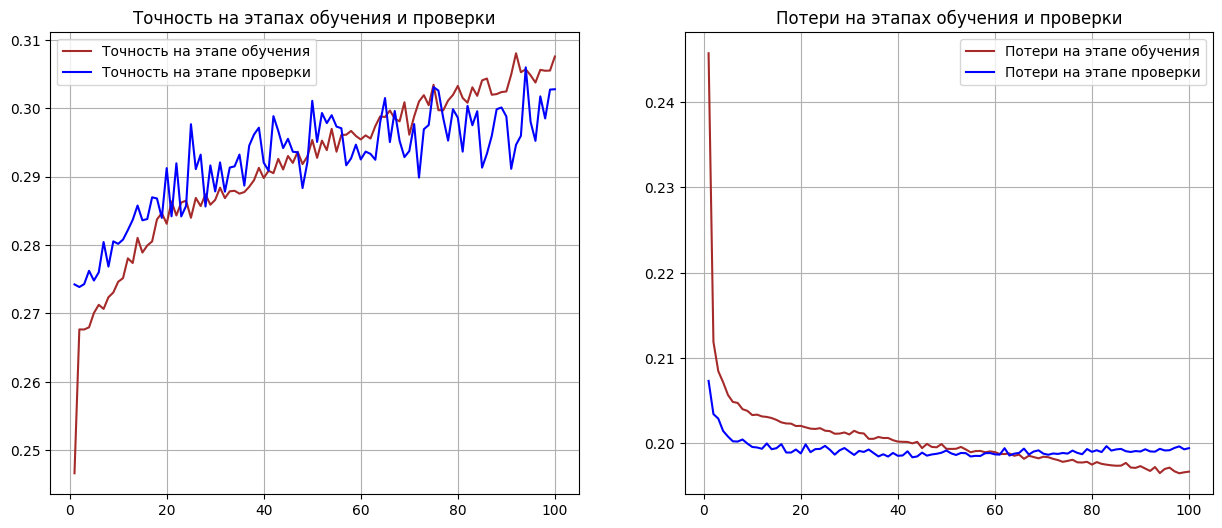

In [ ]:
plothistory(history0, metric='f1_score')
model0.save(diplo+'dknn18/dknn18.keras')

In [ ]:
model0.evaluate(X_test, y_test)

96/96 [==============================] - 0s 2ms/step - loss: 0.2027 - f1_score: 0.2976


[0.20273469388484955, 0.2975667715072632]

# Загрузка модели

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, average_precision_score

In [ ]:
loaded = keras.models.load_model(diplo+'fblood/model_with_many_dropouts.keras')

In [ ]:
loaded.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 86)]              0         
                                                                 
 batch_normalization_1 (Bat  (None, 86)                344       
 chNormalization)                                                
                                                                 
 dense_53 (Dense)            (None, 32)                2784      
                                                                 
 dense_54 (Dense)            (None, 31)                1023      
                                                                 
 dense_55 (Dense)            (None, 10)                320       
                                                                 
 dense_56 (Dense)            (None, 36)                396       
                                                           

In [ ]:
loaded.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': False,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'BinaryCrossentropy',
  'config': {'reduction': 'auto',
   'name': 'binary_crossentropy',
   'from_logits': False,
   'label_smoothing': 0.0,
   'axis': -1,
   'fn': 'binary_crossentropy'},
  'registered_name': None},
 'metrics': {'module': 'keras.metrics',
  'class_name': 'F1Score',
  'config': {'name': 'f1_score',
   'dtype': 'float32',
   'average': 'weighted',
   'threshold': None},
  'registered_name': None},
 'loss_weights': None,
 'weighted_metrics': 

In [ ]:
loaded.get_config()

{'name': 'model_1',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 86),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'registered_name': None,
   'name': 'input_2',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_1',
    'trainable': True,
    'dtype': 'float32',
    'axis': [1],
    'momentum': 0.99,
    'epsilon': 0.001,
    'center': True,
    'scale': True,
    'beta_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'gamma_initializer': {'module': 'keras.initializers',
     'class_name': 'Ones',
     'config': {},
     'registered_name': None},
    'moving_mean_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    

In [ ]:
y_pred = loaded.predict(X_test)
pseudo_pred = np.where(y_pred > 0.466, 1, 0)
f1 = f1_score(y_test, pseudo_pred, average='weighted')
acc = accuracy_score(y_test, pseudo_pred)
logloss = log_loss(y_test, pseudo_pred)
apr = average_precision_score(y_test, pseudo_pred, average='weighted')
print(f'\t\tF1 Score: {f1}; accuracy: {acc}; logloss: {logloss}, aucpr: {apr}')

122/122 [==============================] - 1s 7ms/step
		F1 Score: 0.2824527377682058; accuracy: 0.2359897172236504; logloss: 18.450805577309183, aucpr: 0.2708336378446382


In [ ]:
y_pred = loaded.predict(X_train)
pseudo_pred = np.where(y_pred > 0.466, 1, 0)
f1 = f1_score(y_train, pseudo_pred, average='weighted')
acc = accuracy_score(y_train, pseudo_pred)
logloss = log_loss(y_train, pseudo_pred)
apr = average_precision_score(y_train, pseudo_pred, average='weighted')
print(f'\t\tF1 Score: {f1}; accuracy: {acc}; logloss: {logloss}, aucpr: {apr}')

387/387 [==============================] - 1s 3ms/step
		F1 Score: 0.2984550432631988; accuracy: 0.24581547667178782; logloss: 17.990442041900057, aucpr: 0.28301437880349123


# Та же с батчнорм, но обучается на mice

In [ ]:
X_train, y_train, X_test, y_test, xval, yval = trtestsplit(mX, mY, 0.2)

In [ ]:
def model_builder(hp):
    inp = tf.keras.layers.Input(shape = (X_train.shape[1],))
    x = tf.keras.layers.BatchNormalization()(inp)
    num_layers = hp.Int('num_layers', 3, 66, step=1)
    for i in range(num_layers):
        nunits = hp.Int(f'units{i}', min_value=3, max_value=100)
        act = hp.Choice(f'activation{i}', ['relu', 'sigmoid', 'leaky_relu', 'elu', 'selu', 'swish'])
        x = keras.layers.Dense(units=nunits, activation=act)(x)
    drop_rate = hp.Choice(f'drate{i}', [0.25,0.3,0.35,0.4,0.45,0.5,0.55, 0.6, 0.65,0.7])
    x = keras.layers.Dropout(drop_rate)(x)
    outputs = tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')(x)
    model = keras.Model(inp, outputs)

    #lr = hp.Float('learning_rate', 0.0005, 0.02)

    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(), #learning_rate=lr
                  metrics=keras.metrics.F1Score(average='weighted'))
    return model

In [ ]:
tuner1 = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=200,
                     #validation_data=(xval, yval),
                     directory=diplo+'mice18',
                     project_name='mice18')
callbacks1=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')]#, patience=15
tuner1.search(X_train, y_train, validation_data=(xval, yval),
              epochs = 10, batch_size = 4,
              callbacks = callbacks1, verbose = 1)

Trial 213 Complete [00h 03m 43s]
val_loss: 0.22690460085868835

Best val_loss So Far: 0.20252691209316254
Total elapsed time: 07h 19m 19s

Search: Running Trial #214

Value             |Best Value So Far |Hyperparameter
60                |4                 |num_layers
56                |17                |units0
leaky_relu        |elu               |activation0
21                |52                |units1
selu              |elu               |activation1
72                |52                |units2
relu              |sigmoid           |activation2
0.55              |0.5               |drate2
37                |20                |units3
swish             |swish             |activation3
51                |67                |units4
relu              |swish             |activation4
74                |44                |units5
swish             |swish             |activation5
64                |86                |units6
selu              |leaky_relu        |activation6
3                 |61

In [ ]:
best_hps1 = tuner1.get_best_hyperparameters()
best_hps1[0].values

In [ ]:
best15 = tuner1.get_best_hyperparameters(5)
model1 = tuner1.hypermodel.build(best_hps1[0])
history1 = model1.fit(X_train, y_train, epochs=100, validation_data=(xval, yval))
val_per_epoch1 = history1.history['val_loss']

In [ ]:
model1.summary()

In [ ]:
plothistory(history1, metric='f1_score')
model1.save(diplo+'mice18/mice18.keras')

In [ ]:
model1.evaluate(X_test, y_test)

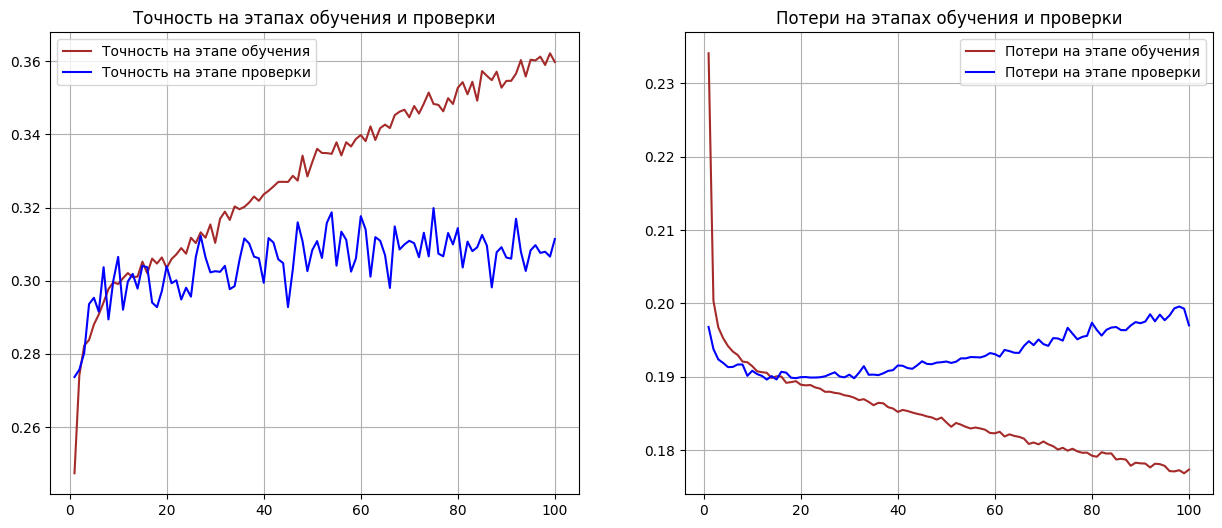

In [ ]:
plothistory(history1, metric='f1_score')
model1.save(diplo+'withbatchanddropout_rmice/withbatchanddropout_rmice.keras')

# MY HyperModel (тюнинг размера батча)

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        inp = tf.keras.layers.Input(shape = (X_train.shape[1],))
        x = tf.keras.layers.BatchNormalization()(inp)
        num_layers = hp.Int('num_layers', 3, 66, step=1)
        for i in range(num_layers):
            nunits = hp.Int(f'units{i}', min_value=3, max_value=100)
            act = hp.Choice(f'activation{i}', ['relu', 'sigmoid', 'leaky_relu', 'elu', 'selu', 'swish'])
            x = keras.layers.Dense(units=nunits, activation=act)(x)
        drop_rate = hp.Choice(f'dp{i}'.format(i=i), [0.25,0.3,0.35,0.4,0.45,0.5,0.55, 0.6, 0.65,0.7])
        x = keras.layers.Dropout(drop_rate)(x)
        outputs = tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')(x)
        model = keras.Model(inp, outputs)

        #lr = hp.Float('learning_rate', 0.0005, 0.02)

        model.compile(loss=keras.losses.BinaryCrossentropy(),
                      optimizer=keras.optimizers.Adam(), #learning_rate=lr
                      metrics=keras.metrics.F1Score(average='weighted'))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [1, 4, 8, 16, 32]),
            #epochs=hp.Int('epochs', 10, 200, step=10),
            **kwargs,
        )

In [ ]:
callbacks1=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)]
tuner1 = kt.BayesianOptimization(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory=diplo+"mblood",
    project_name="hypermodel",
)

In [ ]:
tuner1.search(X_train, y_train, validation_data=(xval, yval),
                epochs = 13, verbose = 1, callbacks = callbacks1)

Trial 2 Complete [00h 02m 41s]

Best val_accuracy So Far: None
Total elapsed time: 00h 39m 32s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
17                |52                |num_layers
56                |80                |units0
leaky_relu        |elu               |activation0
48                |51                |units1
swish             |swish             |activation1
20                |12                |units2
swish             |swish             |activation2
0.5               |0.4               |dp2
63                |3                 |units3
swish             |relu              |activation3
95                |3                 |units4
selu              |relu              |activation4
81                |3                 |units5
relu              |relu              |activation5
75                |3                 |units6
elu               |relu              |activation6
89                |3                 |units7
elu               |relu 

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/usr/local/lib/python3.10/dist-packages/kera

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 116, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/objective.py", line 59, in get_value
    return logs[self.name]
KeyError: 'val_accuracy'


In [ ]:
best5_1 = tuner1.get_best_hyperparameters(5)
best_hps

# TensorBoard

In [ ]:
import tensorboard
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

In [ ]:
%tensorboard --logdir 'logs/'